In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools as im

# 4

In [2]:
x = plt.imread('assets/starfish.png')

In [3]:
y = plt.imread('assets/topgun.png')

Text(0.5, 1.0, 'Random masking')

/Users/eseetao/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


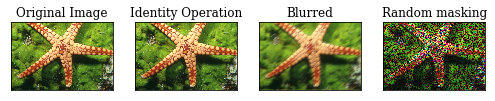

In [4]:
random_masking = im.RandomMasking(x.shape,0.4)
identity = im.Identity(x.shape)
motion_blur = im.Convolution(x.shape,im.kernel("motion"))

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(7,15))
axes[0].imshow(x)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original Image")

axes[1].imshow(identity(x))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Identity Operation")

axes[2].imshow(motion_blur(x))
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("Blurred")

axes[3].imshow(random_masking(x))
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title("Random masking")

# 5

In [5]:
def matrix_product(x,y):
    '''
    computes matrix dot product
    '''
    return np.sum(x*y)

## Random Masking

In [6]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(random_masking(x),y),matrix_product(x,random_masking.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Identity

In [7]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(identity(x),y),matrix_product(x,identity.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Convolution

In [8]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(motion_blur(x),y),matrix_product(x,motion_blur.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


# 6

In [9]:
def inv_gram_res(obj,x,tau):
    '''
    Computes inverse of gram resolvent matrix
    Args:
        obj: operation
        x: input image
        tau: constant of regularization
    Returns:
        inverse of gram resolvent
    '''
    return x + (tau*obj.adjoint(obj(x)))

## Identity

In [10]:
confirm = identity.gram_resolvent(inv_gram_res(identity,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {0}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Random Masking

In [11]:
confirm = random_masking.gram_resolvent(inv_gram_res(random_masking,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Motion Blur

In [12]:
confirm = motion_blur.gram_resolvent(inv_gram_res(motion_blur,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x,atol=1e-2)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


# 8 

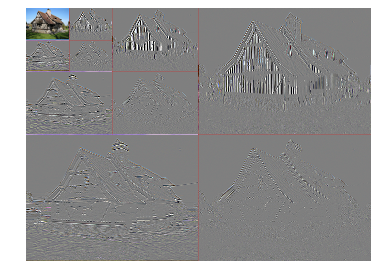

In [13]:
x0 = plt.imread("assets/normandy.png")
J = 3
h,g = im.wavelet('db2')
y0 = im.dwt(im.dwt_crop(x0,J),J,h,g)
im.showdwt(y0,J=3)

# 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


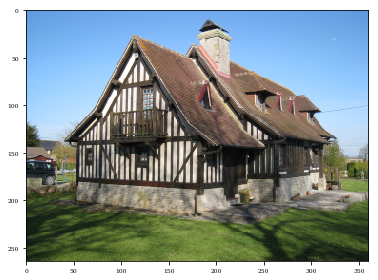

In [14]:
x = im.idwt(y0,J,h,g)
plt.imshow(x)

# 10

In [15]:
confirm = im.dwt(im.idwt(y0,J,h,g),J,h,g)
print("Confirm if dwt is left inverse idwt of {}".format(np.allclose(confirm,y0)))

Confirm if dwt is left inverse idwt of True


In [16]:
confirm = im.idwt(im.dwt(im.dwt_crop(x0,J),J,h,g),J,h,g)
print("Confirm if idwt is left inverse dwt of {}".format(np.allclose(confirm,im.dwt_crop(x0,J))))

Confirm if idwt is left inverse dwt of True


In [17]:
x=im.dwt_crop(plt.imread('assets/starfish.png'),J)
y =im.dwt_crop(plt.imread('assets/topgun.png'),J)
print("Confirm that idwt in adjoint of dwt {}".format(np.allclose(matrix_product(im.dwt(x,J,h,g),y),matrix_product(x,im.idwt(y,J,h,g)))))

Confirm that idwt in adjoint of dwt True


# 12

In [18]:
def softthresh(z,t):
    '''
    Implements soft thresholding of matrix z with threshold t
    Args:
        z: array
        t: threshold
    Returns:
        threshold: thresholded version of z
    '''
    
#     threshold = z.copy()
#     #threshold = 0*(np.abs(z)<t)
#     threshold = threshold*(np.abs(z)>t)
#     threshold = threshold - t*np.sign(threshold-t)
    
    threshold = np.maximum(z-t,np.zeros_like(z))+np.minimum(z+t,np.zeros_like(z))
    
    return threshold

## 13

In [19]:
def softthresh_denoise(y, sig, W, alpha=10/255):
    '''
    Removes noise by performing soft-thresholding on the wavelet coefficients
    Args:
        y: image
        sig: standard deviation
        W: wavelet transformation
    Kwargs:
        alpha: scaling factor
    Returns:
        Denoised image
    '''
    
    coeff = W(y)
    tau = np.sqrt(2)*np.square(sig)/(alpha*W.power())
    return softthresh(coeff,tau)

In [20]:
J=3
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
#psnr = [im.psnr(clean,W.invert(softthresh_denoise(noisy, sig, W, alpha=i/255))) for i in [6/255, 8/255, 10/255, 12/255]]
psnr = [im.psnr(clean,softthresh_denoise(noisy, sig, W, alpha=i/255)) for i in range(3,20)]

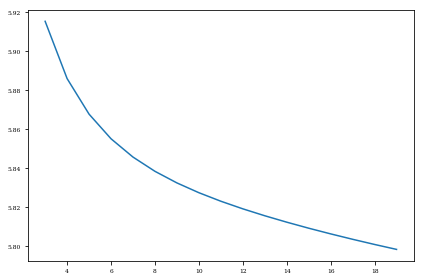

In [21]:
plt.plot([i for i in range(3,20)],psnr)
#plt.plot([i for i in [6/255, 8/255, 10/255, 12/255]],psnr)

## 14 

## 15

In [22]:
def interleave0(x,j):
    '''
    Upsample the filters h and g in udwt by injecting 2^(j − 1) zeros between each entries.
    Args:
        x: input vector
        j: interleaving factor
    Returns:
        x1: interleaved vector
    '''
    x1=np.zeros(((np.shape(x)[0]-1)*pow(2,j)+1,1))
    for i in range(len(x)):
        x1[pow(2,j)*i]=x[i]
    return x1

In [23]:
def udwt(x, J, h, g):
    '''
    Implements the 2d Undecimated Discrete Wavelet Transform (UDWT) with J scales
    Args:
        x: image
        J: scales
        h: filter h
        g: filter g
    Returns:
        z: udwt transformation
    '''
    if J == 0:
        return x[:, :, None]
    tmph = np.rot90(im.convolve(np.rot90(x,k=3), h),k=1) / 2
    tmpg = np.rot90(im.convolve(np.rot90(x,k=3), g),k=1) / 2     
    z = np.stack((im.convolve(tmpg, h),im.convolve(tmph, g),im.convolve(tmph, h)), axis=2)
    coarse = im.convolve(tmpg, g)
    h2 = interleave0(h,J)
    g2 = interleave0(g,J)
    z = np.concatenate((udwt(coarse, J - 1, h2, g2), z),axis=2)
    return z

## 16

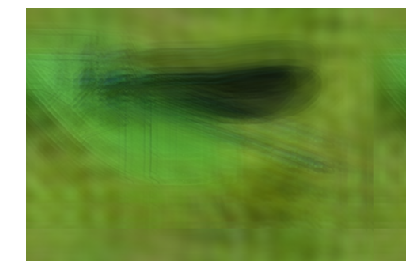

In [24]:
x0 = plt.imread("assets/dragonfly.png")
J = 3
h,g = im.wavelet('db2')
y0=udwt(im.dwt_crop(x0,J),J,h,g)
im.show(y0[:,:,0,:])
plt.show()

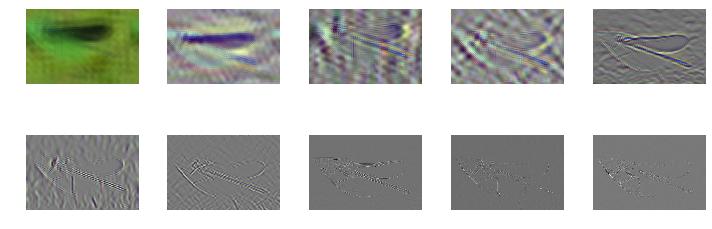

In [25]:
fig,axes= plt.subplots(nrows=2,ncols=5,figsize=(10,5))
im.show(y0[:,:,0,:],ax=axes[0][0])
im.showdwt(y0[:,:,1,:],J=0,ax=axes[0][1])
im.showdwt(y0[:,:,2,:],J=0,ax=axes[0][2])
im.showdwt(y0[:,:,3,:],J=0,ax=axes[0][3])
im.showdwt(y0[:,:,4,:],J=0,ax=axes[0][4])
im.showdwt(y0[:,:,5,:],J=0,ax=axes[1][0])
im.showdwt(y0[:,:,6,:],J=0,ax=axes[1][1])
im.showdwt(y0[:,:,7,:],J=0,ax=axes[1][2])
im.showdwt(y0[:,:,8,:],J=0,ax=axes[1][3])
im.showdwt(y0[:,:,9,:],J=0,ax=axes[1][4])

## 17

In [26]:
def iudwt(z, J, h, g):
    '''
    Implements the 2d Inverse UDWT
    Args:
        z: input img
        J: scales
        h: filter h
        g: filter g
    Returns:
        x: the 2D inverse UDWT
    '''
    if J == 0:
        return z[:, :, 0]
    h2 = interleave0(h,J)
    g2 = interleave0(g,J)
    coarse = iudwt(z[:, :, :-3], J - 1, h2, g2)
    tmpg = im.convolve(coarse, g[::-1]) + im.convolve(z[:, :, -3], h[::-1])
    tmph = im.convolve(z[:, :, -2], g[::-1]) + im.convolve(z[:, :, -1], h[::-1])
    x = (np.rot90(im.convolve(np.rot90(tmpg,k=3), g[::-1]),k=1) + np.rot90(im.convolve(np.rot90(tmph,k=3), h[::-1]),k=1)) / 2
    return x

## 18

In [27]:
print("Checking udwt and iudwt are inverse of each other",np.allclose(iudwt(udwt(im.dwt_crop(x0,J),J,h,g) ,J, h, g),im.dwt_crop(x0,J)))

Checking udwt and iudwt are inverse of each other True


In [28]:
y=udwt(im.dwt_crop(x0,J),J,h,g)

In [29]:
np.allclose(y,udwt(iudwt(y,J, h, g),J, h, g))

False

## 19

In [30]:
def udwt_create_fb(n1, n2, J, h, g, ndim=3):
    '''
    Implements UDWT with filter bank
    Args:
        n1: kernel dim n
        n2: kernel dim m
        J: scales
        h: filter h
        g: filter g
    Kwargs:
        ndim: number of dimensions
    Returns:
        fb: filter bank
    '''
    
    if J == 0:
        return np.ones((n1, n2, 1, *[1] * (ndim - 2)))
    h2 = interleave0(h,J)
    g2 = interleave0(g,J)
    fbrec = udwt_create_fb(n1, n2, J - 1, h2, g2, ndim=ndim)
    gf1 = nf.fft(fftpad(g, n1), axis=0)
    hf1 = nf.fft(fftpad(h, n1), axis=0)
    gf2 = nf.fft(fftpad(g, n2), axis=0)
    hf2 = nf.fft(fftpad(h, n2), axis=0)
    fb = np.zeros((n1, n2, 4), dtype=np.complex128)
    fb[:, :, 0] = np.outer(gf1, gf2) / 2
    fb[:, :, 1] = np.outer(gf1, hf2) / 2
    fb[:, :, 2] = np.outer(hf1, gf2) / 2
    fb[:, :, 3] = np.outer(hf1, hf2) / 2
    fb = fb.reshape(n1, n2, 4, *[1] * (ndim - 2))
    fb = np.concatenate((fb[:, :, 0:1] * fbrec, fb[:, :, -3:]),axis=2)
    return fb

In [31]:
def fb_apply(x, fb):
    '''
    Application of filter bank
    Args:
        x: image 
        fb: filter bank
    Returns:
        z: applied filter bank
    '''
    
    x = nf.fft2(x, axes=(0, 1))
    z = fb * x[:, :, np.newaxis]
    z = np.real(nf.ifft2(z, axes=(0, 1)))
    return z

In [32]:
def fb_adjoint(z, fb):
    '''
    Application of adjoint filter bank
    Args:
        z: input img
        fb: filter bank
    Returns:
        x: adjoint filter bank
    '''
    
    z = nf.fft2(z, axes=(0, 1))
    x = (np.conj(fb) * z).sum(axis=2)
    x = np.real(nf.ifft2(x, axes=(0, 1)))
    return x

## 21

In [33]:
#placeholder for softthresh_denoise 

## 22

In [34]:
def sparse_analysis_regularization(y, sig, W, H=None, m=40, alpha=10/255, gamma=1, return_energy=False):
    '''
    Computes the sparse analysis regularization via wavelet coefficients
    Args:
        y: noisy image
        sig: standard deviation
        W: (undecimated)/discrete wavelet transformation
        H: kernel linear operator
        m: iterations
        alpha: scaling factor
        gamma: must be > 0
    Kwargs:
        return_energy: if False, returns only x, if True, returns both x and e
    Returns:
        x: approximate image
        e: energy
    '''
    #TODO: finish energy eq (list of size m)
    
    n = len(y)
    if not H:
        H = im.Identity(y.shape)
        
    coeff = W(y)
    #tau = np.sqrt(2*np.sqrt(m/n))*np.square(sig) #fix m and n dimensions
    lamb = alpha*W.power()
        
    #initialization
    x_til = H.adjoint(y)
    z_til = coeff*x_til
    dx = 0
    dz = 0
    e = []
    
    tau = np.sqrt(2*np.sqrt(n/len(z_til)))*np.square(sig)
    
    for i in range(m):
        
        x = H.gram_resolvent(x_til+dx+gamma*H.adjoint(y),gamma)
        z = softthresh(z_til+dz,gamma*tau/lamb)
        
        x_til = W.gram_resolvent(x-dx+W.adjoint(z-dz),1)
        z_til = coeff*x_til
        
        dx = dx - x + x_til
        dz = dz - z + z_til
        
        #print("finished", i+1, "iterations")
    
    if return_energy:
        return x, e
    else:
        return x




## 23

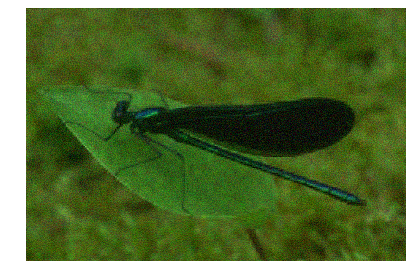

In [35]:
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
y = clean + sig * np.random.randn(*clean.shape)
im.show(y)

DWT_SAR = sparse_analysis_regularization(y, sig, W)
im.show(DWT_SAR)

In [36]:
# clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
# W = im.UDWT(clean.shape,J)
# sig = 20 / 255
# y = clean + sig * np.random.randn(*clean.shape)
# im.show(y)

# UDWT_SAR = sparse_analysis_regularization(y, sig, W)
# im.show(UDWT_SAR)

## 24

In [37]:
#motion_blur = im.Convolution(x.shape,im.kernel("motion"))

clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.DWT(clean.shape,J)
sig = 2 / 255
y = clean + sig * np.random.randn(*clean.shape)
motion_blur = im.Convolution(y.shape,im.kernel("motion"))

H = im.kernel("motion")
DWT_SAR = sparse_analysis_regularization(y, sig, W)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAR with DWT')

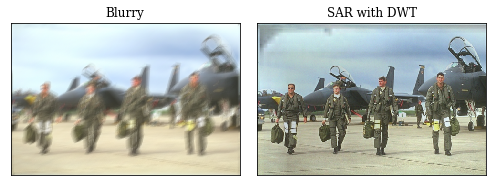

In [38]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(7,15))
axes[0].imshow(motion_blur(y))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Blurry")

axes[1].imshow(DWT_SAR)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT")

#placeholder for UDWT

## 25

In [ ]:
#random masking 40%